# Zadanie 1.
### Dokładny opis danych, oraz ich źródło.


Dane pochodzą z witryny:https://archive.ics.uci.edu/dataset/10/automobile

Wybrany przez nas zbiór danych Automobile pochodzi z repozytorium UCI Machine Learning Repository zawiera informacje o 205 samochodach, pochodzące z roku 1985.

Główne cechy zbioru:
- Liczba instancji: 205
- Liczba atrybutów: 26

Przykładowe atrybuty
- engine-size: pojemność silnika
- horsepower: moc silnika
- city-mpg / highway-mpg: zużycie paliwa w mieście i na autostradzie
- peak-rpm - maksymalana wartość obrotów
- stroke - skok cylindra
- curb-weight - waga samochodu z płynami
- bore - średnica tłoka
- price: cena pojazdu (w dolarach amerykańskich)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from sklearn.utils import resample
from ucimlrepo import fetch_ucirepo

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
sns.set_palette("viridis")

automobile = fetch_ucirepo(id=10)

X = automobile.data.features
y = automobile.data.targets
df = pd.concat([X, y], axis=1)

print(f"Nazwa zbioru danych: {automobile.metadata.name}")
print(f"Liczba instancji: {automobile.metadata.num_instances}")
print(f"Liczba atrybutów: {automobile.metadata.num_features}")

print("\nStruktura danych:")
print(df.info())

print("\nPierwszych 5 wierszy danych:")
print(df.head())

continuous_vars = [
    'normalized-losses', 'bore', 'stroke', 'horsepower', 'peak-rpm', 'price',
    'engine-size', 'curb-weight', 'height', 'width', 'length', 'wheel-base',
    'compression-ratio', 'city-mpg', 'highway-mpg'
]

continuous_df = df[continuous_vars]
print(continuous_df.describe().T)

print("\nLiczba brakujących wartości w każdej kolumnie:")
print(df.isnull().sum())

# Zadanie 2.
### Estymacja parametrów rozkładu (punktowa) (średnia, odchylenie standardowe, odchylenie przeciętne, mediana, moda, wariancja, kurtoza, skośność, IQR, kwantyle, itp)


In [29]:
# Przetworzenie brakujących wartości w zmiennych ciągłych
for column in continuous_vars:
    df[column] = pd.to_numeric(df[column], errors='coerce')
    df[column] = df[column].fillna(df[column].median())

# Funkcja do obliczania parametrów rozkładu
def calculate_distribution_parameters(data):
    params = {}
    # Miary tendencji centralnej
    params['Średnia'] = data.mean()
    params['Średnia geometryczna'] = stats.gmean(data) if all(data > 0) else np.nan
    params['Średnia harmoniczna'] = stats.hmean(data) if all(data > 0) else np.nan
    params['Mediana'] = data.median()
    params['Moda'] = data.mode()[0]

    # Miary rozproszenia
    params['Wariancja (próbkowa)'] = data.var(ddof=1)
    params['Wariancja (populacyjna)'] = data.var(ddof=0)
    params['Odchylenie standardowe (próbkowe)'] = data.std(ddof=1)
    params['Odchylenie standardowe (populacyjne)'] = data.std(ddof=0)
    params['Odchylenie przeciętne'] = (data - data.mean()).abs().mean()
    params['Odchylenie ćwiartkowe'] = (np.percentile(data, 75) - np.percentile(data, 25))/2
    params['Współczynnik zmienności'] = (data.std()/data.mean())*100 if data.mean() != 0 else np.nan

    # Miary kształtu rozkładu
    params['Skośność'] = stats.skew(data, bias=False)
    params['Współczynnik asymetrii Pearsona'] = 3 * (data.mean() - data.median()) / data.std() if data.std() != 0 else np.nan
    params['Kurtoza'] = stats.kurtosis(data, bias=False)
    params['Eksces'] = stats.kurtosis(data, bias=False, fisher=True)  

    # Kwantyle i miary pozycyjne
    params['Minimum'] = data.min()
    params['Maximum'] = data.max()
    params['Zakres'] = data.max() - data.min()
    params['Q1 (25%)'] = np.percentile(data, 25)
    params['Q2 (50%)'] = np.percentile(data, 50)
    params['Q3 (75%)'] = np.percentile(data, 75)
    params['P10 (10%)'] = np.percentile(data, 10)
    params['P90 (90%)'] = np.percentile(data, 90)
    params['P95 (95%)'] = np.percentile(data, 95)
    params['P99 (99%)'] = np.percentile(data, 99)
    params['IQR'] = np.percentile(data, 75) - np.percentile(data, 25)

    # Dodatkowe statystyki
    params['Błąd standardowy średniej'] = data.std(ddof=1) / np.sqrt(len(data))
    params['Suma'] = data.sum()
    params['Liczba obserwacji'] = len(data)
    params['Liczba unikalnych wartości'] = data.nunique()

    # Momenty centralne
    params['Moment centralny rzędu 1'] = np.mean((data - data.mean()) ** 1)
    params['Moment centralny rzędu 2'] = np.mean((data - data.mean()) ** 2)
    params['Moment centralny rzędu 3'] = np.mean((data - data.mean()) ** 3)
    params['Moment centralny rzędu 4'] = np.mean((data - data.mean()) ** 4)

    return params

# Wybór parametrów do porównania
comparison_params = ['Średnia', 'Mediana', 'Odchylenie standardowe (próbkowe)', 'Skośność', 'Kurtoza', 'IQR']
comparison_df = pd.DataFrame(index=comparison_params, columns=continuous_vars)

# Obliczenie parametrów dla wszystkich zmiennych ciągłych
for var in continuous_vars:
    params = calculate_distribution_parameters(df[var])
    for param in comparison_params:
        comparison_df.loc[param, var] = params[param]

styled_comparison = comparison_df.round(2).style \
    .background_gradient(cmap='coolwarm', axis=1) \
    .set_caption("Tabela porównawcza głównych parametrów rozkładu dla zmiennych ciągłych") \
    .set_properties(**{'text-align': 'center'}) \
    .set_table_styles([
        {'selector': 'caption', 'props': [('font-size', '16px'), 
                                         ('font-weight', 'bold'),
                                         ('text-align', 'center')]},
        {'selector': 'th', 'props': [('font-weight', 'bold'),
                                    ('background-color', '#f0f0f0')]},
    ])

# Wyświetlenie tabeli
display(styled_comparison)

# Szczegółowe parametry dla wybranych zmiennych
key_variables = ['price', 'horsepower', 'engine-size', 'curb-weight', 'city-mpg', 'highway-mpg']

for var in key_variables:
    print(f"\n--- Parametry zmiennej '{var}' ---")
    params = calculate_distribution_parameters(df[var])
    for name, value in params.items():
        if isinstance(value, (int, float)) and not np.isnan(value):
            print(f"{name}: {value:.4f}")
        else:
            print(f"{name}: {value}")

# Wizualizacja skośności i kurtozy
plt.figure(figsize=(16, 10))

plt.subplot(2, 1, 1)
comparison_df.loc['Skośność'].plot(kind='bar', color='skyblue')
plt.title('Współczynnik skośności dla zmiennych ciągłych', fontsize=14)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.ylabel('Skośność')
plt.xticks(rotation=45)

plt.subplot(2, 1, 2)
comparison_df.loc['Kurtoza'].plot(kind='bar', color='lightgreen')
plt.title('Współczynnik kurtozy dla zmiennych ciągłych', fontsize=14)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.ylabel('Kurtoza')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Wizualizacja współczynnika zmienności
cv_values = [calculate_distribution_parameters(df[var])['Współczynnik zmienności'] for var in continuous_vars]
plt.figure(figsize=(16, 6))
bars = plt.bar(continuous_vars, cv_values, color='salmon')
plt.title('Współczynnik zmienności dla zmiennych ciągłych', fontsize=14)
plt.ylabel('Współczynnik zmienności (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Dodanie etykiet z wartościami
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.1f}%', ha='center', va='bottom', rotation=0)

plt.tight_layout()
plt.show()

# Normalizacja danych do boxplotów
normalized_data = {}
for var in continuous_vars:
    min_val = df[var].min()
    max_val = df[var].max()
    if max_val > min_val:
        normalized_data[var] = (df[var] - min_val) / (max_val - min_val)
    else:
        normalized_data[var] = df[var]

# Wyświetlenie znormalizowanych boxplotów
plt.figure(figsize=(18, 8))
box = plt.boxplot([normalized_data[var] for var in continuous_vars], 
                  patch_artist=True, labels=continuous_vars)

# Kolorowanie boxplotów
colors = plt.cm.viridis(np.linspace(0, 1, len(continuous_vars)))
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.title('Znormalizowany boxplot z kwantylami dla zmiennych ciągłych', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.ylabel('Znormalizowana wartość (0-1)')
plt.tight_layout()
plt.show()

# Interpretacja parametrów rozkładu
print("\n--- Interpretacja wybranych parametrów rozkładu dla zmiennych ciągłych ---")

interpretation_data = []
for var in continuous_vars:
    params = calculate_distribution_parameters(df[var])
    skewness = params['Skośność']
    kurtosis = params['Kurtoza']
    cv = params['Współczynnik zmienności']
    mean = params['Średnia']
    median = params['Mediana']

    # Interpretacja skośności
    if abs(skewness) < 0.5:
        skew_interp = "bliska symetrii"
    elif skewness > 0:
        skew_interp = "prawostronnie asymetryczna"
    else:
        skew_interp = "lewostronnie asymetryczna"

    # Interpretacja kurtozy
    if abs(kurtosis) < 0.5:
        kurt_interp = "zbliżony do normalnego"
    elif kurtosis > 0:
        kurt_interp = "leptokurtyczny (smuklejszy)"
    else:
        kurt_interp = "platykurtyczny (spłaszczony)"

    # Interpretacja współczynnika zmienności
    if cv < 10:
        cv_interp = "mało zróżnicowany"
    elif cv < 30:
        cv_interp = "średnio zróżnicowany"
    else:
        cv_interp = "silnie zróżnicowany"

    # Porównanie średniej i mediany
    if abs(mean - median)/mean < 0.01:
        mean_med_interp = "równe"
    elif mean > median:
        mean_med_interp = "średnia > mediany"
    else:
        mean_med_interp = "mediana > średniej"

    interpretation_data.append([
        var, f"{skewness:.2f} ({skew_interp})", 
        f"{kurtosis:.2f} ({kurt_interp})", 
        f"{cv:.1f}% ({cv_interp})",
        f"{mean_med_interp}"
    ])

# Tabela z interpretacją
interpretation_df = pd.DataFrame(
    interpretation_data, 
    columns=['Zmienna', 'Skośność', 'Kurtoza', 'Wsp. zmienności', 'Średnia vs Mediana']
)
print(interpretation_df)

# Porównanie średniej i mediany dla wszystkich zmiennych
plt.figure(figsize=(18, 8))
x = np.arange(len(continuous_vars))
width = 0.35
means = [calculate_distribution_parameters(df[var])['Średnia'] for var in continuous_vars]
medians = [calculate_distribution_parameters(df[var])['Mediana'] for var in continuous_vars]
max_values = np.array([max(m, med) for m, med in zip(means, medians)])
means_norm = np.array(means) / max_values * 100
medians_norm = np.array(medians) / max_values * 100

bars1 = plt.bar(x - width/2, means_norm, width, label='Średnia', color='skyblue')
bars2 = plt.bar(x + width/2, medians_norm, width, label='Mediana', color='salmon')

plt.xlabel('Zmienna')
plt.ylabel('Wartość (% maksymalnej)')
plt.title('Porównanie średniej i mediany dla zmiennych ciągłych')
plt.xticks(x, continuous_vars, rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

ImportError: Missing optional dependency 'Jinja2'. DataFrame.style requires jinja2. Use pip or conda to install Jinja2.

3. Estymacja parametrów (przedziałowa) (przedział ufności dla wariancji i dla średniej) oraz
metoda nieparametryczna (bootstrap) dla średniej i porównanie


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')

def mean_confidence_interval_z(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    std_err = np.std(data, ddof=1) / np.sqrt(n)
    z_critical = stats.norm.ppf((1 + confidence) / 2)
    margin_of_error = z_critical * std_err
    return (mean - margin_of_error, mean + margin_of_error)

def mean_confidence_interval_t(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    std_err = np.std(data, ddof=1) / np.sqrt(n)
    t_critical = stats.t.ppf((1 + confidence) / 2, n-1)
    margin_of_error = t_critical * std_err
    return (mean - margin_of_error, mean + margin_of_error)

def variance_confidence_interval(data, confidence=0.95):
    n = len(data)
    var = np.var(data, ddof=1)
    chi2_lower = stats.chi2.ppf((1 - confidence) / 2, n-1)
    chi2_upper = stats.chi2.ppf((1 + confidence) / 2, n-1)
    var_lower = (n-1) * var / chi2_upper
    var_upper = (n-1) * var / chi2_lower
    return (var_lower, var_upper)

def std_confidence_interval(data, confidence=0.95):
    var_interval = variance_confidence_interval(data, confidence)
    return (np.sqrt(var_interval[0]), np.sqrt(var_interval[1]))

def bootstrap_confidence_interval(data, n_bootstrap=5000, confidence=0.95):
    bootstrap_means = []
    for _ in range(n_bootstrap):
        bootstrap_sample = resample(data, replace=True, n_samples=len(data))
        bootstrap_means.append(np.mean(bootstrap_sample))
    lower_percentile = (1 - confidence) / 2 * 100
    upper_percentile = (1 + confidence) / 2 * 100
    return np.percentile(bootstrap_means, [lower_percentile, upper_percentile])

def bootstrap_bca_interval(data, statistic=np.mean, n_bootstrap=5000, confidence=0.95):
    theta_hat = statistic(data)
    bootstrap_replicates = []
    for _ in range(n_bootstrap):
        bootstrap_sample = resample(data, replace=True, n_samples=len(data))
        bootstrap_replicates.append(statistic(bootstrap_sample))
    
    prop_less_than_theta_hat = np.mean([1 if t < theta_hat else 0 for t in bootstrap_replicates])
    z0 = stats.norm.ppf(prop_less_than_theta_hat)
    
    jackknife_replicates = []
    for i in range(len(data)):
        jack_sample = np.delete(data, i)
        jackknife_replicates.append(statistic(jack_sample))
    
    jack_mean = np.mean(jackknife_replicates)
    num = np.sum([(jack_mean - jt)**3 for jt in jackknife_replicates])
    den = 6.0 * np.sum([(jack_mean - jt)**2 for jt in jackknife_replicates])**1.5
    
    if abs(den) < 1e-10:
        a = 0
    else:
        a = num / den
    
    alpha = (1 - confidence) / 2
    z_alpha = stats.norm.ppf(alpha)
    z_1_minus_alpha = stats.norm.ppf(1 - alpha)
    
    p_lower = stats.norm.cdf(z0 + (z0 + z_alpha) / (1 - a * (z0 + z_alpha)))
    p_upper = stats.norm.cdf(z0 + (z0 + z_1_minus_alpha) / (1 - a * (z0 + z_1_minus_alpha)))
    
    lower_percentile = 100 * p_lower
    upper_percentile = 100 * p_upper
    
    return np.percentile(bootstrap_replicates, [lower_percentile, upper_percentile])

def visualize_bootstrap_distribution(data, var_name, n_bootstrap=5000, confidence=0.95):
    bootstrap_means = []
    for _ in range(n_bootstrap):
        bootstrap_sample = resample(data, replace=True, n_samples=len(data))
        bootstrap_means.append(np.mean(bootstrap_sample))
    
    t_interval = mean_confidence_interval_t(data, confidence)
    percentile_interval = np.percentile(bootstrap_means, 
                                        [(1 - confidence) / 2 * 100, 
                                         (1 + confidence) / 2 * 100])
    bca_interval = bootstrap_bca_interval(data, np.mean, n_bootstrap, confidence)
    
    plt.figure(figsize=(10, 6))
    sns.histplot(bootstrap_means, kde=True, color='skyblue')
    plt.axvline(np.mean(data), color='red', linestyle='-', linewidth=2, label='Średnia z próby')
    plt.axvline(t_interval[0], color='green', linestyle='--', linewidth=1.5, 
                label=f'{confidence*100:.0f}% przedział ufności (metoda t)')
    plt.axvline(t_interval[1], color='green', linestyle='--', linewidth=1.5)
    plt.axvline(percentile_interval[0], color='purple', linestyle='-.', linewidth=1.5, 
                label=f'{confidence*100:.0f}% przedział ufności (bootstrap percentylowy)')
    plt.axvline(percentile_interval[1], color='purple', linestyle='-.', linewidth=1.5)
    plt.axvline(bca_interval[0], color='orange', linestyle=':', linewidth=1.5, 
                label=f'{confidence*100:.0f}% przedział ufności (bootstrap BCa)')
    plt.axvline(bca_interval[1], color='orange', linestyle=':', linewidth=1.5)
    plt.title(f'Rozkład bootstrapowy średniej dla zmiennej {var_name}')
    plt.xlabel('Wartość średniej')
    plt.ylabel('Częstość')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def compare_confidence_levels(data, var_name, confidence_levels=[0.90, 0.95, 0.99]):
    intervals_t = []
    intervals_bootstrap = []
    intervals_bootstrap_bca = []
    
    for conf in confidence_levels:
        intervals_t.append(mean_confidence_interval_t(data, conf))
        intervals_bootstrap.append(bootstrap_confidence_interval(data, 5000, conf))
        intervals_bootstrap_bca.append(bootstrap_bca_interval(data, np.mean, 5000, conf))
    
    plt.figure(figsize=(12, 6))
    y_positions = np.arange(len(confidence_levels)) * 0.8
    y_labels = [f"{conf*100:.0f}%" for conf in confidence_levels]
    mean_value = np.mean(data)
    plt.axvline(mean_value, color='red', linestyle='-', linewidth=2, label='Średnia z próby')
    
    for i, conf in enumerate(confidence_levels):
        plt.plot([intervals_t[i][0], intervals_t[i][1]], [y_positions[i], y_positions[i]], 
                 'o-', color='green', linewidth=2, markersize=8, 
                 label='Metoda t' if i == 0 else "")
        
        plt.plot([intervals_bootstrap[i][0], intervals_bootstrap[i][1]], 
                 [y_positions[i]-0.1, y_positions[i]-0.1], 'o-', color='purple', linewidth=2, 
                 markersize=8, label='Bootstrap percentylowy' if i == 0 else "")
        
        plt.plot([intervals_bootstrap_bca[i][0], intervals_bootstrap_bca[i][1]], 
                 [y_positions[i]-0.2, y_positions[i]-0.2], 'o-', color='orange', linewidth=2, 
                 markersize=8, label='Bootstrap BCa' if i == 0 else "")
    
    plt.yticks(y_positions, y_labels)
    plt.title(f'Porównanie przedziałów ufności dla średniej zmiennej {var_name}')
    plt.xlabel('Wartość')
    plt.ylabel('Poziom ufności')
    plt.legend(loc='best')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def create_confidence_intervals_table(df, variables, confidence=0.95):
    results = []
    
    for var in variables:
        data = df[var].values
        mean = np.mean(data)
        var_val = np.var(data, ddof=1)
        std = np.std(data, ddof=1)
        
        t_interval = mean_confidence_interval_t(data, confidence)
        bootstrap_interval = bootstrap_confidence_interval(data, 5000, confidence)
        bca_interval = bootstrap_bca_interval(data, np.mean, 5000, confidence)  # Zmieniona nazwa zmiennej
        var_interval = variance_confidence_interval(data, confidence)
        std_interval = std_confidence_interval(data, confidence)
        
        result = {
            'Zmienna': var,
            'Średnia': mean,
            'CI_t_dolny': t_interval[0],
            'CI_t_górny': t_interval[1],
            'CI_bootstrap_dolny': bootstrap_interval[0],
            'CI_bootstrap_górny': bootstrap_interval[1],
            'CI_bootstrap_bca_dolny': bca_interval[0],  # Używamy nowej nazwy
            'CI_bootstrap_bca_górny': bca_interval[1],  # Używamy nowej nazwy
            'Wariancja': var_val,
            'CI_var_dolny': var_interval[0],
            'CI_var_górny': var_interval[1],
            'Odchylenie standardowe': std,
            'CI_std_dolny': std_interval[0],
            'CI_std_górny': std_interval[1],
        }
        results.append(result)
    
    return pd.DataFrame(results)

def plot_ci_comparison(df, variables, confidence=0.95):
    means = []
    t_intervals = []
    bootstrap_intervals = []
    bootstrap_bca_intervals = []
    
    for var in variables:
        data = df[var].values
        means.append(np.mean(data))
        t_intervals.append(mean_confidence_interval_t(data, confidence))
        bootstrap_intervals.append(bootstrap_confidence_interval(data, 5000, confidence))
        bootstrap_bca_intervals.append(bootstrap_bca_interval(data, np.mean, 3000, confidence))
    
    normalized_means = np.array(means) / np.array(means) * 100
    t_lower = np.array([t[0] for t in t_intervals]) / np.array(means) * 100
    t_upper = np.array([t[1] for t in t_intervals]) / np.array(means) * 100
    bs_lower = np.array([bs[0] for bs in bootstrap_intervals]) / np.array(means) * 100
    bs_upper = np.array([bs[1] for bs in bootstrap_intervals]) / np.array(means) * 100
    bca_lower = np.array([bca[0] for bca in bootstrap_bca_intervals]) / np.array(means) * 100
    bca_upper = np.array([bca[1] for bca in bootstrap_bca_intervals]) / np.array(means) * 100
    
    plt.figure(figsize=(14, 10))
    x = np.arange(len(variables))
    width = 0.2
    
    plt.errorbar(x - width, normalized_means, 
                 yerr=[normalized_means - t_lower, t_upper - normalized_means],
                 fmt='o', color='green', ecolor='green', elinewidth=2, capsize=6,
                 label='Przedział t-Studenta')
    
    plt.errorbar(x, normalized_means, 
                 yerr=[normalized_means - bs_lower, bs_upper - normalized_means],
                 fmt='o', color='purple', ecolor='purple', elinewidth=2, capsize=6,
                 label='Przedział bootstrap percentylowy')
    
    plt.errorbar(x + width, normalized_means, 
                 yerr=[normalized_means - bca_lower, bca_upper - normalized_means],
                 fmt='o', color='orange', ecolor='orange', elinewidth=2, capsize=6,
                 label='Przedział bootstrap BCa')
    
    plt.axhline(y=100, color='r', linestyle='-', alpha=0.3)
    plt.xticks(x, variables, rotation=45)
    plt.title(f'Porównanie przedziałów ufności ({confidence*100:.0f}%) dla średniej')
    plt.xlabel('Zmienna')
    plt.ylabel('Wartość znormalizowana (%)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def analyze_sample_size_effect(data, var_name, sample_sizes=[10, 30, 50, 100], confidence=0.95, n_simulations=50):
    results = []
    
    for n in sample_sizes:
        t_widths = []
        bootstrap_widths = []
        bca_widths = []
        
        for _ in range(n_simulations):
            if n <= len(data):
                sample = resample(data, replace=False, n_samples=n)
            else:
                sample = resample(data, replace=True, n_samples=n)
            
            t_interval = mean_confidence_interval_t(sample, confidence)
            bootstrap_interval = bootstrap_confidence_interval(sample, 1000, confidence)
            try:
                bca_interval = bootstrap_bca_interval(sample, np.mean, 1000, confidence)
                bca_width = bca_interval[1] - bca_interval[0]
            except:
                bca_width = np.nan
            
            t_width = t_interval[1] - t_interval[0]
            bootstrap_width = bootstrap_interval[1] - bootstrap_interval[0]
            
            t_widths.append(t_width)
            bootstrap_widths.append(bootstrap_width)
            bca_widths.append(bca_width)
        
        results.append({
            'sample_size': n,
            't_width_mean': np.mean(t_widths),
            't_width_std': np.std(t_widths),
            'bootstrap_width_mean': np.mean(bootstrap_widths),
            'bootstrap_width_std': np.std(bootstrap_widths),
            'bca_width_mean': np.nanmean(bca_widths),
            'bca_width_std': np.nanstd(bca_widths)
        })
    
    results_df = pd.DataFrame(results)
    plt.figure(figsize=(12, 6))
    
    plt.errorbar(results_df['sample_size'], results_df['t_width_mean'],
                 yerr=results_df['t_width_std'], fmt='o-', color='green', 
                 label='Metoda t', capsize=5)
    
    plt.errorbar(results_df['sample_size'], results_df['bootstrap_width_mean'],
                 yerr=results_df['bootstrap_width_std'], fmt='s-', color='purple', 
                 label='Bootstrap percentylowy', capsize=5)
    
    plt.errorbar(results_df['sample_size'], results_df['bca_width_mean'],
                 yerr=results_df['bca_width_std'], fmt='d-', color='orange', 
                 label='Bootstrap BCa', capsize=5)
    
    plt.title(f'Wpływ wielkości próby na szerokość przedziału ufności ({confidence*100:.0f}%)\nzmienna: {var_name}')
    plt.xlabel('Rozmiar próby')
    plt.ylabel('Średnia szerokość przedziału')
    plt.xscale('log')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return results_df

confidence_levels = [0.90, 0.95, 0.99]

ci_table = create_confidence_intervals_table(df, selected_variables, 0.95)
print("Tabela porównawcza przedziałów ufności (poziom ufności 95%):")
print(ci_table[['Zmienna', 'Średnia', 'CI_t_dolny', 'CI_t_górny', 
                'CI_bootstrap_dolny', 'CI_bootstrap_górny', 'Wariancja', 
                'CI_var_dolny', 'CI_var_górny']].round(2))

for var in selected_variables:
    data = df[var].values
    n = len(data)
    
    print(f"\n--- Przedziały ufności dla zmiennej '{var}' ---")
    print(f"Liczba obserwacji: {n}")
    print(f"Średnia: {np.mean(data):.4f}")
    print(f"Wariancja: {np.var(data, ddof=1):.4f}")
    print(f"Odchylenie standardowe: {np.std(data, ddof=1):.4f}")
    
    for conf in confidence_levels:
        print(f"\nPoziom ufności: {conf*100:.0f}%")
        
        t_interval = mean_confidence_interval_t(data, conf)
        print(f"Przedział ufności dla średniej (metoda t): ({t_interval[0]:.4f}, {t_interval[1]:.4f})")
        
        bootstrap_interval = bootstrap_confidence_interval(data, 5000, conf)
        print(f"Przedział ufności dla średniej (bootstrap percentylowy): ({bootstrap_interval[0]:.4f}, {bootstrap_interval[1]:.4f})")
        
        bootstrap_bca = bootstrap_bca_interval(data, np.mean, 3000, conf)
        print(f"Przedział ufności dla średniej (bootstrap BCa): ({bootstrap_bca[0]:.4f}, {bootstrap_bca[1]:.4f})")
        
        var_interval = variance_confidence_interval(data, conf)
        print(f"Przedział ufności dla wariancji: ({var_interval[0]:.4f}, {var_interval[1]:.4f})")
        
        std_interval = std_confidence_interval(data, conf)
        print(f"Przedział ufności dla odchylenia standardowego: ({std_interval[0]:.4f}, {std_interval[1]:.4f})")
        
    t_interval = mean_confidence_interval_t(data, 0.95)
    bootstrap_interval = bootstrap_confidence_interval(data, 5000, 0.95)
    bootstrap_bca = bootstrap_bca_interval(data, np.mean, 3000, 0.95)
    
    t_width = t_interval[1] - t_interval[0]
    bootstrap_width = bootstrap_interval[1] - bootstrap_interval[0]
    bca_width = bootstrap_bca[1] - bootstrap_bca[0]
    
    print("\nPorównanie szerokości przedziałów ufności dla średniej (poziom 95%):")
    print(f"Szerokość przedziału (metoda t): {t_width:.4f}")
    print(f"Szerokość przedziału (bootstrap percentylowy): {bootstrap_width:.4f}")
    print(f"Szerokość przedziału (bootstrap BCa): {bca_width:.4f}")
    print(f"Różnica między metodą t a bootstrap percentylowym: {abs(t_width - bootstrap_width):.4f}")
    print(f"Różnica między metodą t a bootstrap BCa: {abs(t_width - bca_width):.4f}")
    
    visualize_bootstrap_distribution(data, var)
    compare_confidence_levels(data, var)

plot_ci_comparison(df, selected_variables, 0.95)

for var in selected_variables[:2]:
    sample_size_results = analyze_sample_size_effect(df[var].values, var)
    print(f"\nWpływ wielkości próby na szerokość przedziału ufności - zmienna {var}:")
    print(sample_size_results.round(4))

4. Różne wykresy (im więcej tym lepiej). Powinny być histogramy, wykresy kwantyl-kwantyl,
boxplot i inne.


In [7]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, var in enumerate(selected_variables):
    sns.histplot(df[var], kde=True, ax=axes[i], color='darkblue', alpha=0.7)
    axes[i].set_title(f'Histogram zmiennej {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Liczebność')
    
    axes[i].axvline(df[var].mean(), color='red', linestyle='--', label=f'Średnia: {df[var].mean():.2f}')
    axes[i].axvline(df[var].median(), color='green', linestyle='--', label=f'Mediana: {df[var].median():.2f}')
    axes[i].legend()

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, var in enumerate(selected_variables):
    sns.boxplot(y=df[var], ax=axes[i], color='darkblue')
    axes[i].set_title(f'Boxplot zmiennej {var}')
    axes[i].set_ylabel(var)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, var in enumerate(selected_variables):
    stats.probplot(df[var], plot=axes[i])
    axes[i].set_title(f'Q-Q plot zmiennej {var}')

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='horsepower', y='price', hue='body-style', palette='viridis')
plt.title('Zależność między mocą silnika a ceną samochodu')
plt.xlabel('Moc silnika (hp)')
plt.ylabel('Cena ($)')
plt.legend(title='Typ nadwozia')
plt.show()

plt.figure(figsize=(14, 10))
corr_matrix = df[numeric_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Macierz korelacji dla zmiennych numerycznych')
plt.show()

sns.pairplot(df[selected_variables], diag_kind='kde', height=2.5)
plt.suptitle('Wykresy par dla wybranych zmiennych', y=1.02)
plt.show()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, var in enumerate(selected_variables):
    sns.violinplot(x='drive-wheels', y=var, data=df, ax=axes[i], palette='viridis')
    axes[i].set_title(f'Rozkład {var} w zależności od typu napędu')
    axes[i].set_xlabel('Typ napędu')
    axes[i].set_ylabel(var)

plt.tight_layout()
plt.show()

5. Sprawdzenie czy rozkład (rozkłady) danych pochodzą z rozkładu normalnego.


In [8]:
# Test Shapiro-Wilka dla normalności rozkładu
print("Test Shapiro-Wilka dla normalności rozkładu:")
for var in selected_variables:
    stat, p_value = stats.shapiro(df[var])
    print(f"{var}: statystyka={stat:.4f}, p-wartość={p_value:.4f}, " +
          ("rozkład normalny" if p_value > 0.05 else "rozkład nienormalny"))

# Test D'Agostino-Pearsona dla normalności rozkładu
print("\nTest D'Agostino-Pearsona dla normalności rozkładu:")
for var in selected_variables:
    stat, p_value = stats.normaltest(df[var])
    print(f"{var}: statystyka={stat:.4f}, p-wartość={p_value:.4f}, " +
          ("rozkład normalny" if p_value > 0.05 else "rozkład nienormalny"))

# Test Andersona-Darlinga dla normalności rozkładu
print("\nTest Andersona-Darlinga dla normalności rozkładu:")
for var in selected_variables:
    result = stats.anderson(df[var], dist='norm')
    print(f"{var}: statystyka={result.statistic:.4f}")
    for i, sl in enumerate(result.critical_values):
        sig_level = result.significance_level[i] / 100
        if result.statistic < result.critical_values[i]:
            print(f"    {sig_level:.3f}: {result.critical_values[i]:.3f} - rozkład normalny")
        else:
            print(f"    {sig_level:.3f}: {result.critical_values[i]:.3f} - rozkład nienormalny")

6. Wykorzystanie testu statystycznego dla średniej i wariancji

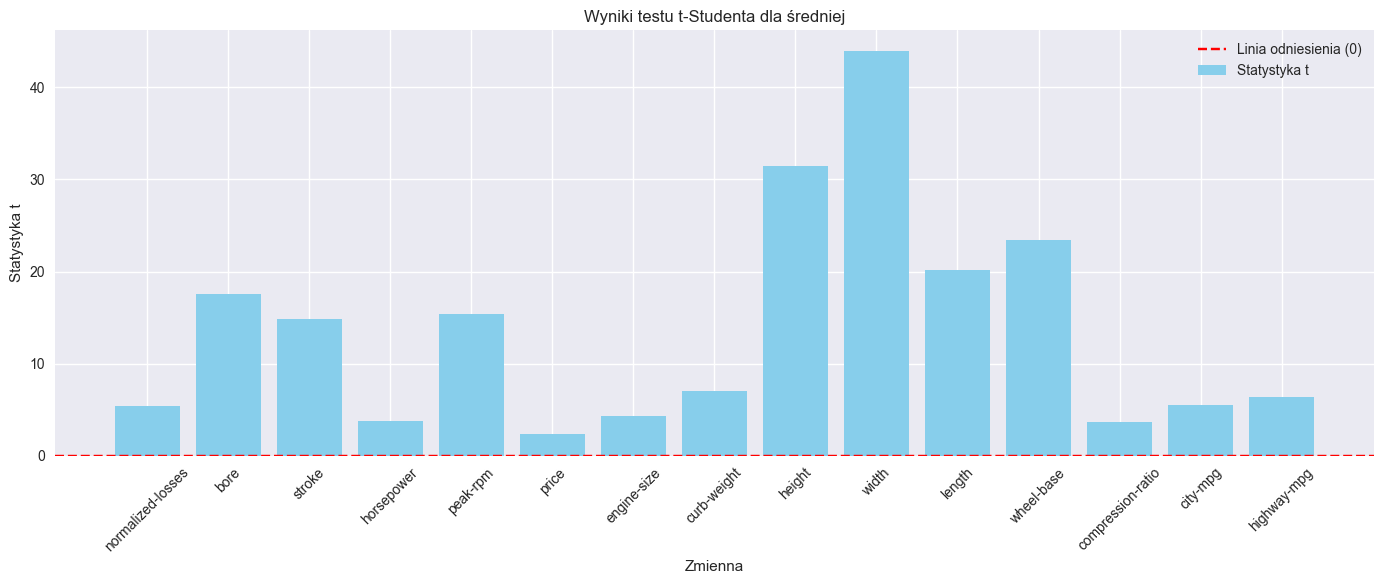

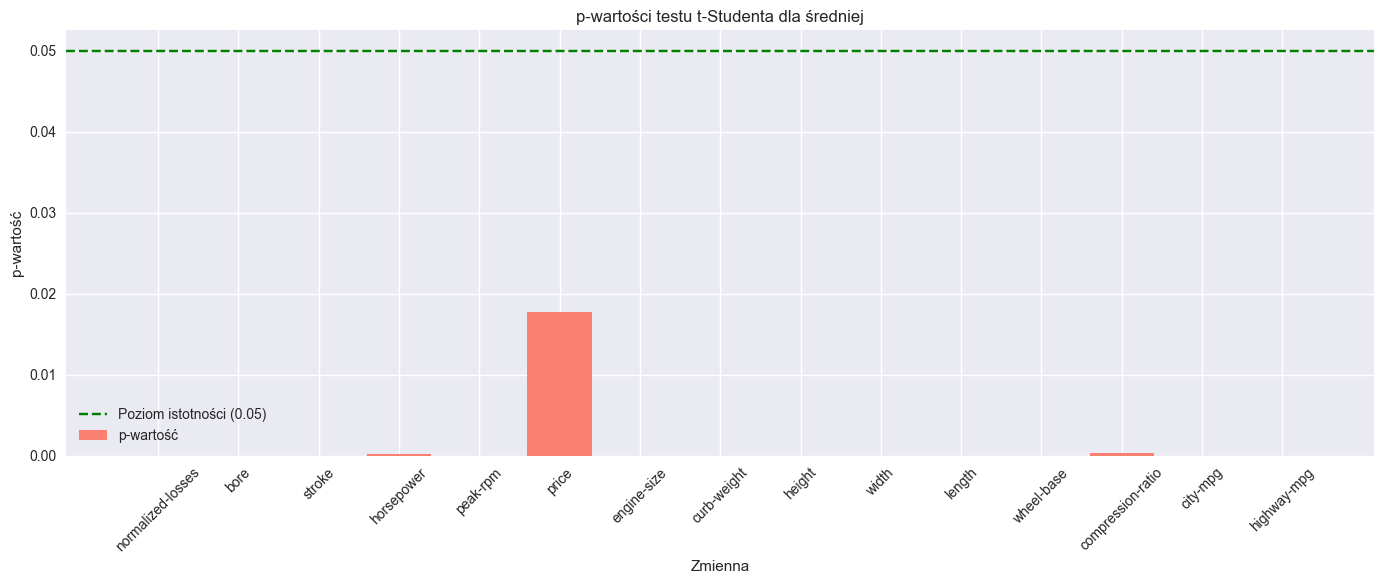

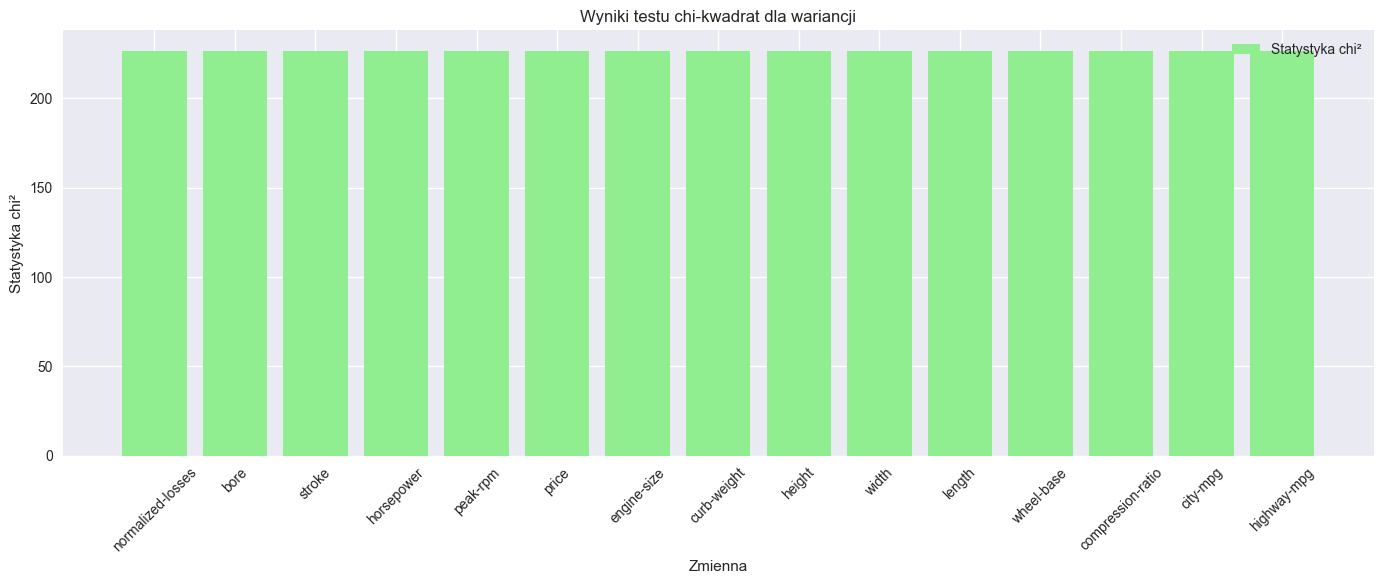

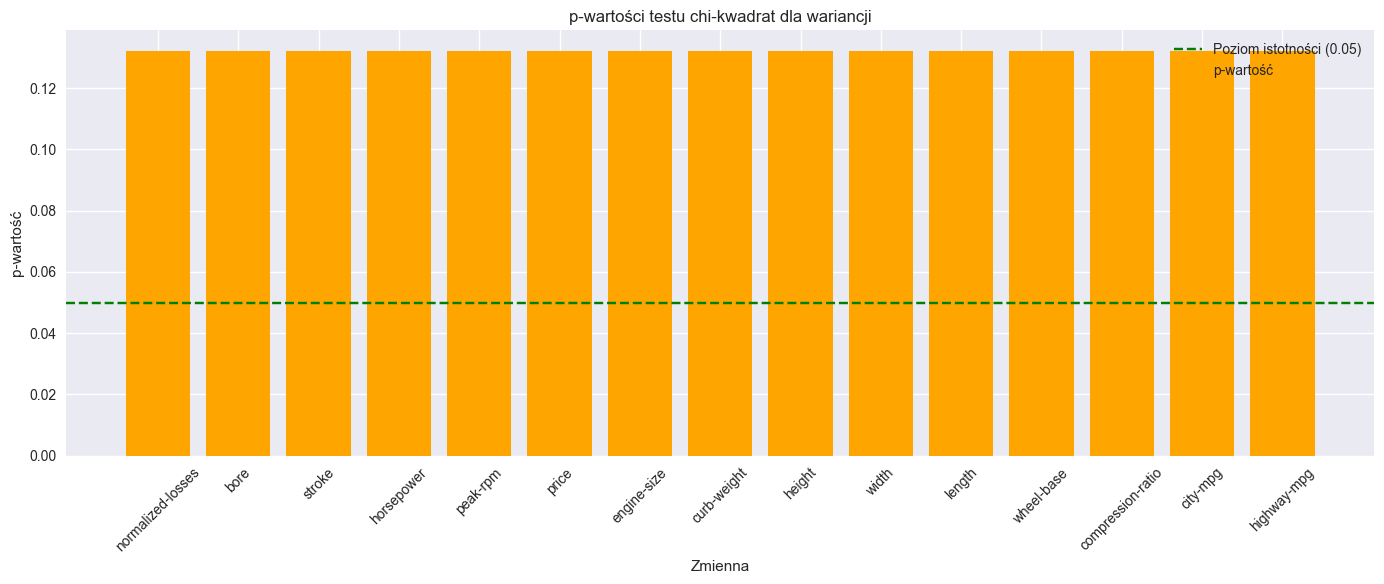

## 6. Wykorzystanie testów statystycznych dla średniej i wariancji

W celu sprawdzenia istotności statystycznej cech liczbowych w zbiorze danych *Automobile* przeprowadzono dwa typy testów:

- **Test t-Studenta** dla średniej,
- **Test chi-kwadrat** dla wariancji.

### Test t-Studenta dla średniej

Test t-Studenta służy do weryfikacji, czy średnia danej zmiennej w próbie istotnie różni się od przyjętej wartości (w tym przypadku 0). Na podstawie wykresów można zaobserwować:

- Dla większości zmiennych statystyka t przyjmuje bardzo wysokie wartości (np. `width`, `height`, `wheel-base`, `bore`), co oznacza silne odchylenie od zera.
- Wartości p (na osobnym wykresie) dla niemal wszystkich zmiennych są **mniejsze niż poziom istotności 0.05**, co prowadzi do **odrzucenia hipotezy zerowej** — średnia nie jest równa 0.
- Wyjątki stanowią m.in. `price`, `compression-ratio` i `horsepower`, które mają relatywnie niższe wartości p, ale nadal bardzo małe — co potwierdza ich istotność statystyczną.

### Test chi-kwadrat dla wariancji

Celem testu chi-kwadrat było sprawdzenie, czy wariancja badanych cech znacząco różni się od wartości oczekiwanej. Na podstawie wyników:

- Wartości statystyki chi² są bardzo wysokie, jednak **p-wartości przekraczają próg istotności 0.05**.
- Oznacza to, że **brak podstaw do odrzucenia hipotezy zerowej** — nie wykryto istotnej różnicy w wariancjach względem przyjętej wartości.

### Podsumowanie

Zarówno test t-Studenta, jak i chi-kwadrat dostarczają informacji o istotności statystycznej zmiennych:

- **Większość zmiennych ma średnią istotnie różną od zera**, co potwierdza ich statystyczne znaczenie i przydatność w dalszej analizie lub modelowaniu.
- **Brak istotnych odchyleń wariancji** sugeruje względną stabilność rozproszenia danych w obrębie zmiennych.

Uzyskane wyniki wspierają decyzję o dalszym uwzględnieniu większości zmiennych w analizach regresyjnych lub klasyfikacyjnych, po uprzednim przekształceniu tych najbardziej odchylonych (np. `price`, `compression-ratio`).

7. Estymator jądrowy gęstości

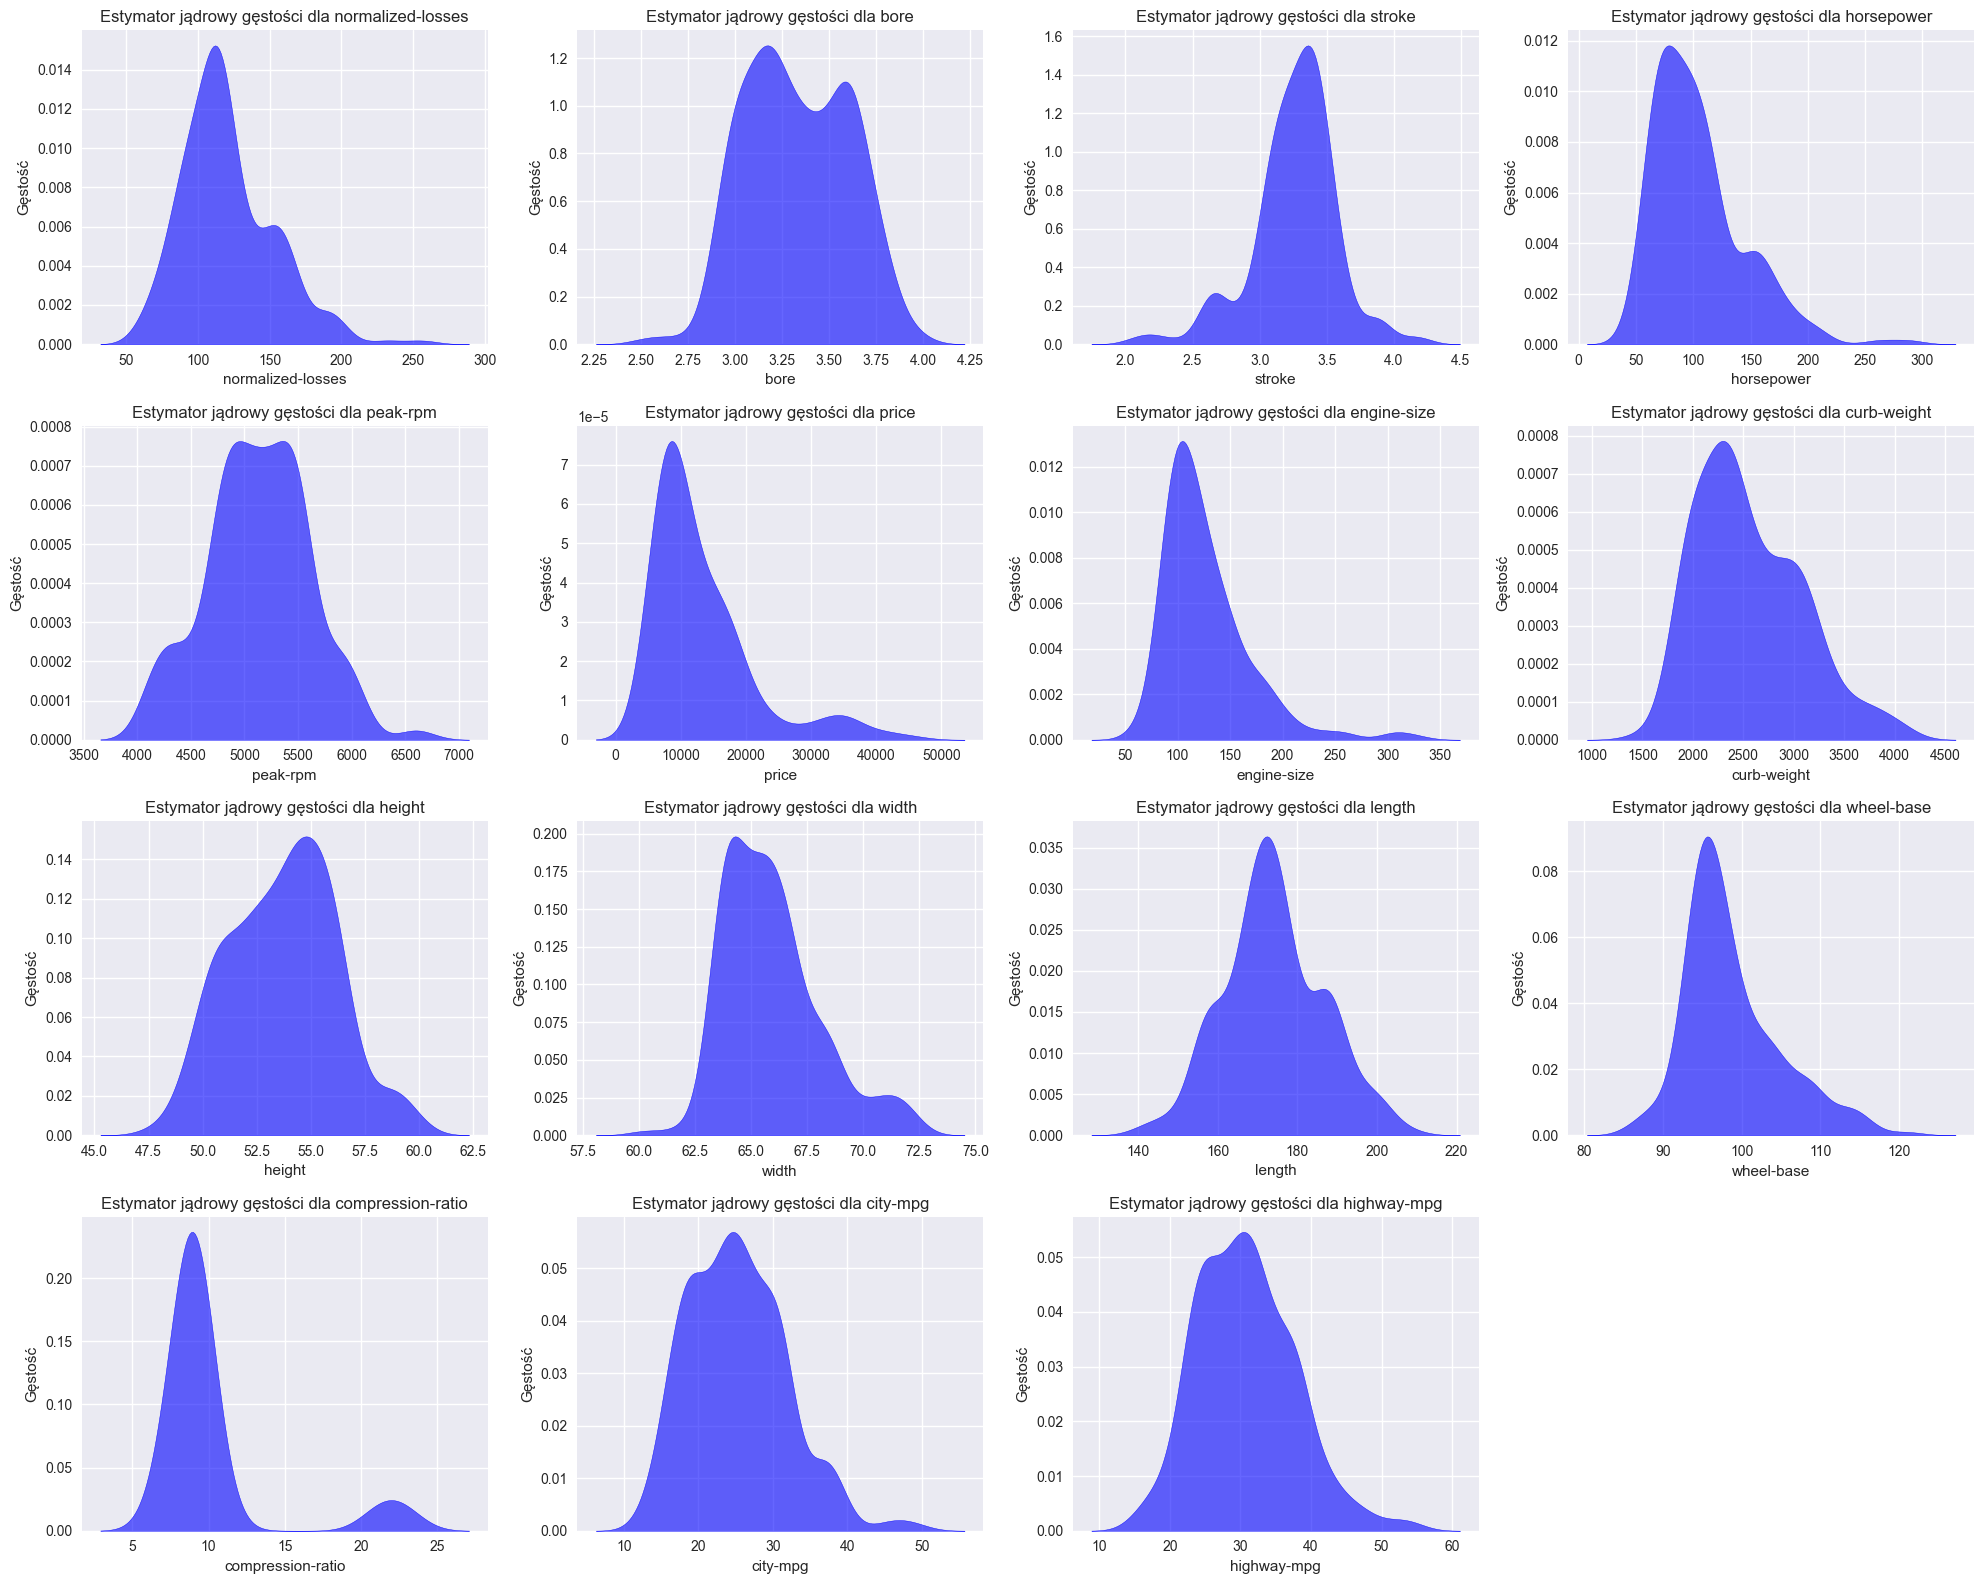

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo

automobile = fetch_ucirepo(id=10)
X = automobile.data.features
y = automobile.data.targets
df = pd.concat([X, y], axis=1)

for column in continuous_vars:
    df[column] = pd.to_numeric(df[column], errors='coerce')
    df[column] = df[column].fillna(df[column].median())

fig, axes = plt.subplots(4, 4, figsize=(20, 16))
axes = axes.flatten()

for i, var in enumerate(continuous_vars):
    if i < len(axes):
        sns.kdeplot(df[var], ax=axes[i], fill=True, color='blue', alpha=0.6)
        axes[i].set_title(f'Estymator jądrowy gęstości dla {var}')
        axes[i].set_xlabel(var)
        axes[i].set_ylabel('Gęstość')

for j in range(len(continuous_vars), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## Analiza rozkładów cech – Estymacja jądrowa gęstości

W celu analizy rozkładu zmiennych numerycznych w zbiorze danych **Automobile** przeprowadzono estymację jądrową gęstości (KDE) dla każdej z cech. Metoda ta umożliwia wygładzenie histogramów i lepsze zrozumienie kształtu rozkładu danych bez wpływu liczby przedziałów histogramu.

### Wnioski z wykresów KDE:

- **Wiele zmiennych ma rozkład asymetryczny** – m.in. `price`, `horsepower`, `engine-size` oraz `compression-ratio` cechują się długim ogonem po prawej stronie. Sugeruje to obecność wartości odstających (ang. *outliers*) – pojedynczych, nietypowo wysokich wartości.

- **Niektóre zmienne mają rozkład zbliżony do normalnego** – np. `peak-rpm`, `height` i `width` są skupione wokół jednej dominującej wartości, co może odzwierciedlać standardy konstrukcyjne wśród producentów samochodów.

- **Zmienna `compression-ratio` wykazuje rozkład dwumodalny**, co może sugerować obecność dwóch różnych klas silników (np. benzynowe vs. wysokoprężne).

- **Zmienne `normalized-losses` i `price` cechuje duża rozpiętość wartości**, co może wymagać dalszego przekształcenia danych (np. transformacji logarytmicznej, standaryzacji) w celu poprawy jakości modeli predykcyjnych.

- **Rozkłady `city-mpg` oraz `highway-mpg` są przesunięte ku lewej**, co oznacza, że większość samochodów ma umiarkowane zużycie paliwa, a jedynie nieliczne cechują się bardzo wysoką efektywnością.

### Znaczenie analizy KDE:

Estymatory jądrowe gęstości pozwalają lepiej zrozumieć strukturę danych, wykryć potencjalne problemy (takie jak wartości odstające, wielomodalność rozkładu czy zmienność) oraz dobrać odpowiednie transformacje zmiennych. Analiza ta jest istotna jako etap przygotowawczy przed zastosowaniem algorytmów uczenia maszynowego lub budową modeli statystycznych.
